In [1]:
# install python libraries
!pip install pyLDAvis
!pip install -U gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=2ab8b03c7fe5d0af56639f5027a5298f69d36b8a2c875ea759adc5206be3ba87
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 1.4 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [2]:
# import required libraries

import pandas as pd
import os
import re
import string
import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.feature_extraction import text

from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
# read article data
data = pd.read_csv('/content/sample_data/newsarticles.csv',encoding='latin1',engine='python',error_bad_lines=False)

In [6]:
data.head()

Article      Date  \
0  KARACHI: The Sindh government has decided to b...  1/1/2015   
1  HONG KONG: Asian markets started 2015 on an up...  1/2/2015   
2  HONG KONG:  Hong Kong shares opened 0.66 perce...  1/5/2015   
3  HONG KONG: Asian markets tumbled Tuesday follo...  1/6/2015   
4  NEW YORK: US oil prices Monday slipped below $...  1/6/2015   

                                             Heading  NewsType  
0  sindh govt decides to cut public transport far...  business  
1                    asia stocks up in new year trad  business  
2           hong kong stocks open 0.66 percent lower  business  
3             asian stocks sink euro near nine year   business  
4                 us oil prices slip below 50 a barr  business

In [7]:
data.shape

(2692, 4)

In [8]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, 
    remove punctuation, remove read errors,
    and remove words containing numbers.'''
    text_l = text.split(':')
    if len(text_l)>1:
      text = text_l[1]
    text = text.lower()
    text = text.strip()
    text = re.sub('\[.*?\]', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\w*\d\w*', ' ', text)
    text = re.sub('�', ' ', text)
    return text


# Clean Article Text
data["clean_text"] = data["Article"].apply(lambda x: clean_text(x))

In [9]:
data.head()

Article      Date  \
0  KARACHI: The Sindh government has decided to b...  1/1/2015   
1  HONG KONG: Asian markets started 2015 on an up...  1/2/2015   
2  HONG KONG:  Hong Kong shares opened 0.66 perce...  1/5/2015   
3  HONG KONG: Asian markets tumbled Tuesday follo...  1/6/2015   
4  NEW YORK: US oil prices Monday slipped below $...  1/6/2015   

                                             Heading  NewsType  \
0  sindh govt decides to cut public transport far...  business   
1                    asia stocks up in new year trad  business   
2           hong kong stocks open 0.66 percent lower  business   
3             asian stocks sink euro near nine year   business   
4                 us oil prices slip below 50 a barr  business   

                                          clean_text  
0  the sindh government has decided to bring down...  
1  asian markets started   on an upswing in limit...  
2  hong kong shares opened     percent lower mond...  
3  asian markets tumbled tuesday following painfu...  
4  us oil prices monday slipped below    a barrel...

###  Models

1.   NMF
2.   LSI
3. HDP





In [10]:
import os
import re
import operator
import matplotlib.pyplot as plt
import warnings
import gensim
import numpy as np
warnings.filterwarnings('ignore')

from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel, Nmf
# from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from pprint import pprint

%matplotlib inline

In [11]:
# Noun extract and lemmatize function
def nouns(text):
    '''Given a string of text, tokenize the text 
    and pull out only the nouns.'''

    # create mask to isolate words that are nouns
    is_noun = lambda pos: pos[:2] == 'NN'

    # store function to split string of words 
    # into a list of words (tokens)
    tokenized = word_tokenize(text)

    # store function to lemmatize each word
    wordnet_lemmatizer = WordNetLemmatizer()

    # use list comprehension to lemmatize all words 
    # and create a list of all nouns
    all_nouns = [wordnet_lemmatizer.lemmatize(word) \
    for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 

    # remove words having single character
    all_nouns = [word for word in all_nouns if len(word)>1]
    
    #return list of nouns
    return all_nouns


# Create dataframe of only nouns from article text
data['nouns'] = data.clean_text.apply(nouns)

In [12]:
# remove articles which have 2 or less than 2 nouns in it
data = data[data.nouns.apply(len)>2]
data.shape

(2690, 6)

In [13]:
# create corpus and dictionary
train_texts = data['nouns'].tolist()
dictionary = Dictionary(train_texts)
corpus = [dictionary.doc2bow(text) for text in train_texts]

In [14]:
# NMF Model
nmfmodel = Nmf(corpus=corpus, num_topics=7, id2word=dictionary, kappa=0.1, eval_every=5)

nmftopics = nmfmodel.show_topics(formatted=False)

In [15]:
pprint(nmftopics)

[(0,
  [('test', 0.02122622910371606),
   ('day', 0.01565456433442584),
   ('oil', 0.01497093313550779),
   ('england', 0.014599591212410916),
   ('wicket', 0.013543303442330566),
   ('year', 0.010129756399009026),
   ('ball', 0.00981162766381626),
   ('series', 0.008957337172901848),
   ('match', 0.008446885402836344),
   ('inning', 0.008335498366831092)]),
 (1,
  [('percent', 0.050360537515603716),
   ('government', 0.019640412253088463),
   ('market', 0.01725610822780943),
   ('bank', 0.016741927464972477),
   ('rate', 0.015689425268523745),
   ('gold', 0.011715639978780704),
   ('stock', 0.010565367148686177),
   ('investor', 0.009575501526369984),
   ('policy', 0.0092939953578909),
   ('tax', 0.00918546044551223)]),
 (2,
  [('price', 0.04534399712724257),
   ('oil', 0.042128824352993685),
   ('percent', 0.040546356168575035),
   ('market', 0.0358098211829995),
   ('barrel', 0.01655416158164349),
   ('crude', 0.01638501928797337),
   ('cent', 0.012969426321329962),
   ('week', 0.01

In [16]:
# LSI Model
lsimodel = LsiModel(corpus=corpus, num_topics=7, id2word=dictionary)

lsitopics = lsimodel.show_topics(formatted=False)

In [17]:
pprint(lsitopics)

[(0,
  [('percent', -0.43195094065016765),
   ('year', -0.3790513237118572),
   ('oil', -0.26638301749925125),
   ('market', -0.2598727409403448),
   ('price', -0.23441896309937968),
   ('week', -0.15114026190030616),
   ('month', -0.1486141532080774),
   ('rate', -0.12541426530571187),
   ('dollar', -0.12392208133794871),
   ('barrel', -0.12327919156878157)]),
 (1,
  [('test', 0.32010072527804917),
   ('wicket', 0.2644120021100029),
   ('match', 0.254869270382859),
   ('ball', 0.2425941489618451),
   ('england', 0.21637597468811173),
   ('team', 0.21397322209901715),
   ('cricket', 0.20075432357201028),
   ('run', 0.18990716995371953),
   ('pakistan', 0.18250430889796213),
   ('percent', -0.16908498679916872)]),
 (2,
  [('oil', 0.47677355129178856),
   ('price', 0.31762917167552285),
   ('percent', -0.2940918919116063),
   ('year', -0.24673634928253774),
   ('barrel', 0.24668600312831865),
   ('crude', 0.21227024385370843),
   ('tax', -0.17939229325716424),
   ('government', -0.144067

In [18]:
# HDP Model
# An HDP model is fully unsupervised. It can also determine the ideal number of topics it needs through posterior inference.

hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)
hdptopics = hdpmodel.show_topics(formatted=False)
pprint(hdptopics)

[(0,
  [('year', 0.012152191897954318),
   ('percent', 0.008923384546992348),
   ('world', 0.00836066524424276),
   ('test', 0.008009119451335023),
   ('match', 0.006674499557630864),
   ('pakistan', 0.0062854361693355084),
   ('day', 0.006061732820368104),
   ('team', 0.005932272519015756),
   ('england', 0.005907809305682961),
   ('time', 0.005742416000160209),
   ('oil', 0.005221125845415964),
   ('market', 0.005099355652300192),
   ('week', 0.00488283598479506),
   ('cricket', 0.0048528613825227105),
   ('ball', 0.004813837366619234),
   ('month', 0.004802980069881701),
   ('wicket', 0.004756721793421133),
   ('country', 0.0044914307745610735),
   ('price', 0.0044539333802619055),
   ('game', 0.0042658913503016566)]),
 (1,
  [('year', 0.010455265797427704),
   ('test', 0.008417010351442633),
   ('percent', 0.0073886997221797954),
   ('team', 0.007293050508543867),
   ('world', 0.006666120111244167),
   ('wicket', 0.0063677698224155485),
   ('match', 0.006061001830138205),
   ('day'

### LDA Model

In [19]:
ldamodel = LdaModel(corpus=corpus, num_topics=7, id2word=dictionary)
ldatopics = ldamodel.show_topics(formatted=False)
pprint(ldatopics)

[(0,
  [('time', 0.015680037),
   ('world', 0.015188901),
   ('year', 0.013752998),
   ('game', 0.013034831),
   ('goal', 0.011265492),
   ('team', 0.011000174),
   ('minute', 0.009161278),
   ('tournament', 0.0070787645),
   ('player', 0.006691523),
   ('champion', 0.006656927)]),
 (1,
  [('year', 0.021717452),
   ('percent', 0.021446249),
   ('oil', 0.009565097),
   ('price', 0.009422262),
   ('dollar', 0.008921713),
   ('market', 0.007869094),
   ('world', 0.006980992),
   ('rate', 0.0068423105),
   ('month', 0.006713609),
   ('growth', 0.006461555)]),
 (2,
  [('test', 0.019390777),
   ('england', 0.017382294),
   ('bank', 0.011011886),
   ('wicket', 0.008103879),
   ('inning', 0.007923837),
   ('series', 0.0077040303),
   ('pakistan', 0.007512669),
   ('time', 0.0070092105),
   ('day', 0.0069229016),
   ('run', 0.006816502)]),
 (3,
  [('test', 0.017335387),
   ('wicket', 0.016952092),
   ('day', 0.0151955495),
   ('match', 0.012887462),
   ('oil', 0.012775723),
   ('ball', 0.012641

In [20]:
#Finding out the optimal number of topics using topic coherence

def evaluate_graph(dictionary, corpus, texts, min_limit, max_limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(min_limit, max_limit):
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(min_limit, max_limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

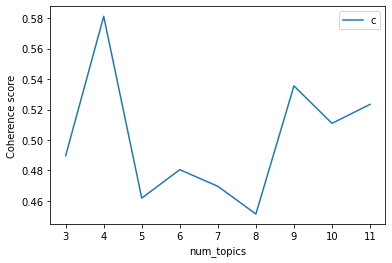

CPU times: user 38.5 s, sys: 443 ms, total: 39 s
Wall time: 38.6 s


In [21]:
%%time
lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=train_texts, min_limit=3, max_limit=12)

In [22]:
# best model among optimal number of topics 
#kindly choose the index position for best model from above graph 
idx = 1
lda_best_topics = lmlist[idx].show_topics(formatted=False)#lmlist = all topic models


In [23]:
pprint(lda_best_topics)

[(0,
  [('test', 0.017784625),
   ('wicket', 0.014328707),
   ('match', 0.012981457),
   ('ball', 0.011137791),
   ('england', 0.010764882),
   ('day', 0.009941837),
   ('run', 0.0097793285),
   ('time', 0.008747045),
   ('year', 0.008516566),
   ('game', 0.008235858)]),
 (1,
  [('year', 0.018914),
   ('percent', 0.018225651),
   ('market', 0.010725237),
   ('country', 0.007838904),
   ('bank', 0.007471677),
   ('month', 0.007326239),
   ('world', 0.0069959513),
   ('pakistan', 0.0067159403),
   ('state', 0.0062336265),
   ('trade', 0.0062118745)]),
 (2,
  [('team', 0.013891726),
   ('year', 0.01384643),
   ('pakistan', 0.011714164),
   ('test', 0.010396759),
   ('england', 0.010380915),
   ('cricket', 0.008888631),
   ('world', 0.007970229),
   ('match', 0.007238772),
   ('series', 0.006261878),
   ('game', 0.0061196475)]),
 (3,
  [('oil', 0.021326615),
   ('year', 0.014660945),
   ('price', 0.013563455),
   ('percent', 0.009252942),
   ('barrel', 0.008790746),
   ('crude', 0.00748392

In [24]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [25]:
# visualizing the model which had best coherence score from above #topics evaluation

# trying model having 5 number of topics as it gave best coherence score in above chart
pyLDAvis.gensim_models.prepare(lmlist[idx], corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.107909 -0.029383       1        1  34.743538
0     -0.137075  0.007317       2        1  27.658057
3      0.046980  0.070481       3        1  19.682188
2     -0.017814 -0.048415       4        1  17.916218, topic_info=         Term         Freq        Total Category  logprob  loglift
118       oil  1424.000000  1424.000000  Default  30.0000  30.0000
3517     test  1906.000000  1906.000000  Default  29.0000  29.0000
6963   wicket  1177.000000  1177.000000  Default  28.0000  28.0000
121   percent  2083.000000  2083.000000  Default  27.0000  27.0000
4478  england  1264.000000  1264.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
439     state   147.115611   782.794941   Topic4  -5.6395   0.0478
5939     ball   150.049578  1041.020383   Topic4  -5.6198  -0.2175
166      week   131.950253   910.220684   Topic4  -5.7483  -0.2118
121   percent   146.461014  2083.588604   Topic4  -5.6440  -0.9356
36       bank   125.987855   822.846584   Topic4  -5.7946  -0.1571

[350 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
5581       1  0.092299      airbus
5581       2  0.023075      airbus
5581       3  0.876843      airbus
5581       4  0.023075      airbus
10886      3  0.134754         alt
...      ...       ...         ...
1924       3  0.043622        yuan
1924       4  0.014541        yuan
9777       3  0.876475      zidane
9777       4  0.073040      zidane
13361      2  0.970829  zimbabwean

[860 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 4, 3])

In [26]:
# One of the problem with LDA is that if we train it on a large number of topics, the topics get "lost" among the numbers. 
# Let us try to dig out the best topics from the best LDA model we can produce. 
# The function below can be used to control the quality of the LDA model we produce.

In [27]:
#lda_top_model

threshold = 0.6 # you can change to a higher number but it will take more time

def ret_top_model():
    """
    Since LDAmodel is a probabilistic model, it comes up different topics each time we run it. To control the
    quality of the topic model we produce, we can see what the interpretability of the best topic is and keep
    evaluating the topic model until this threshold is crossed. 
    
    Returns:
    -------
    lm: Final evaluated topic model
    top_topics: ranked topics in decreasing order. List of tuples
    """
    top_topics = [(0, 0)]
    while top_topics[0][1] < threshold:
        lm = LdaModel(corpus=corpus, id2word=dictionary)
        coherence_values = {}
        for n, topic in lm.show_topics(num_topics=-1, formatted=False):
            topic = [word for word, _ in topic]
            cm = CoherenceModel(topics=[topic], texts=train_texts, dictionary=dictionary, window_size=10)
            coherence_values[n] = cm.get_coherence()
        top_topics = sorted(coherence_values.items(), key=operator.itemgetter(1), reverse=True)
    return lm, top_topics

In [28]:
%%time
lm, top_topics = ret_top_model()

CPU times: user 2min 49s, sys: 7.53 s, total: 2min 57s
Wall time: 2min 50s


In [29]:
print(top_topics[:5])

[(45, 0.7669027642923181), (81, 0.7344718709147446), (19, 0.7315435313664795), (59, 0.7265489794961217), (10, 0.7244815709445508)]


In [30]:
pprint([lm.show_topic(topicid) for topicid, c_v in top_topics[:5]])

[[('ball', 0.04777086),
  ('wicket', 0.039300643),
  ('run', 0.033480715),
  ('inning', 0.02078294),
  ('over', 0.017294977),
  ('century', 0.014122519),
  ('four', 0.01376857),
  ('zimbabwe', 0.013325604),
  ('match', 0.013264618),
  ('bowler', 0.009048319)],
 [('wicket', 0.03650396),
  ('england', 0.028051643),
  ('ball', 0.022385018),
  ('match', 0.016817492),
  ('test', 0.016554562),
  ('stump', 0.015073455),
  ('run', 0.01427384),
  ('day', 0.01376086),
  ('century', 0.013378473),
  ('inning', 0.012563219)],
 [('oil', 0.046565477),
  ('price', 0.03750141),
  ('output', 0.024374343),
  ('barrel', 0.022998044),
  ('market', 0.022223271),
  ('production', 0.021981934),
  ('crude', 0.021577332),
  ('deal', 0.015461627),
  ('opec', 0.015321182),
  ('year', 0.014657659)],
 [('test', 0.049424164),
  ('wicket', 0.026112115),
  ('day', 0.025389584),
  ('run', 0.023982018),
  ('zealand', 0.023259766),
  ('series', 0.020253118),
  ('ball', 0.018584073),
  ('match', 0.017964266),
  ('over', 0

In [31]:
#lda_top_topics = lm.show_topic(topicid) for topicid, c_v in top_topics

### Evaluating all topics model

In [32]:
#NMF
nmftopics_1 = [[word for word, prob in topic] for topicid, topic in nmftopics]

#LSI
lsitopics_1 = [[word for word, prob in topic] for topicid, topic in lsitopics]

#HDP
hdptopics_1 = [[word for word, prob in topic] for topicid, topic in hdptopics]

#LDA
ldatopics_1 = [[word for word, prob in topic] for topicid, topic in ldatopics]

# best LDA from optimal number of topics evaluation using topic coherence
lda_best_topics_1 = [[word for word, prob in topic] for topicid, topic in lda_best_topics]

# top LDA model based on user defined topic coherence threshold (we gave 0.6)
lda_top_topics_1 = [[word for word, prob in lm.show_topic(topicid)] for topicid, c_v in top_topics]

In [33]:

nmf_coherence = CoherenceModel(topics=nmftopics_1[:7], texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

lsi_coherence = CoherenceModel(topics=lsitopics_1[:7], texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

hdp_coherence = CoherenceModel(topics=hdptopics_1[:7], texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

lda_coherence = CoherenceModel(topics=ldatopics_1, texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

lm_best_coherence = CoherenceModel(topics=lda_best_topics_1, texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

lda_top_coherence = CoherenceModel(topics=lda_top_topics_1[:7], texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

In [34]:
def evaluate_bar_graph(coherences, indices):
    """
    Function to plot bar graph.
    
    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

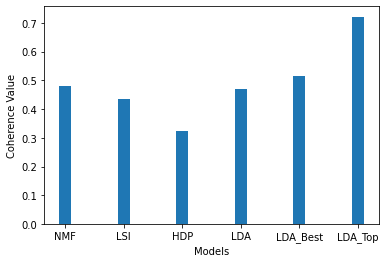

In [35]:
evaluate_bar_graph([nmf_coherence, lsi_coherence, hdp_coherence, lda_coherence, lm_best_coherence, lda_top_coherence],
                   ['NMF', 'LSI', 'HDP', 'LDA', 'LDA_Best', 'LDA_Top'])

### NMF Topic Modeling using scikit learn (you can ignore)

In [36]:
# Noun extract and lemmatize function
def nouns(text):
    '''Given a string of text, tokenize the text 
    and pull out only the nouns.'''
    # create mask to isolate words that are nouns
    is_noun = lambda pos: pos[:2] == 'NN'
    # store function to split string of words 
    # into a list of words (tokens)
    tokenized = word_tokenize(text)
    # store function to lemmatize each word
    wordnet_lemmatizer = WordNetLemmatizer()
    # use list comprehension to lemmatize all words 
    # and create a list of all nouns
    all_nouns = [wordnet_lemmatizer.lemmatize(word) \
    for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    
    #return string of joined list of nouns
    return ' '.join(all_nouns)


# Create dataframe of only nouns from articles text
data['nouns'] = data.clean_text.apply(nouns)

In [37]:
# Add additional stop words since we are recreating the document-term matrix
# stop_noun = ["strong", 'DUBAI', 'WASHINGTON', 'BEIJING']
# stop_words_noun_agg = text.ENGLISH_STOP_WORDS.union(stop_noun)
stopwords = stopwords.words('english')

# Create a document-term matrix with only nouns
# Store TF-IDF Vectorizer
tv_noun = TfidfVectorizer(stop_words=stopwords, ngram_range = (1,2), max_df = .8, min_df = .01)

# Fit and Transform speech noun text to a TF-IDF Doc-Term Matrix
data_tv_noun = tv_noun.fit_transform(data.nouns)

In [38]:
# Create data-frame of Doc-Term Matrix with nouns as column names
data_dtm_noun = pd.DataFrame(data_tv_noun.toarray(), columns=tv_noun.get_feature_names())

# Visually inspect Document Term Matrix
data_dtm_noun.head()

aaron   ab  ab villiers  ability  absence  access  account  achievement  \
0    0.0  0.0          0.0      0.0      0.0     0.0      0.0          0.0   
1    0.0  0.0          0.0      0.0      0.0     0.0      0.0          0.0   
2    0.0  0.0          0.0      0.0      0.0     0.0      0.0          0.0   
3    0.0  0.0          0.0      0.0      0.0     0.0      0.0          0.0   
4    0.0  0.0          0.0      0.0      0.0     0.0      0.0          0.0   

   act    action  ...       yen  yen york  yield      york  younis  yuan  \
0  0.0  0.000000  ...  0.000000       0.0    0.0  0.000000     0.0   0.0   
1  0.0  0.000000  ...  0.055148       0.0    0.0  0.000000     0.0   0.0   
2  0.0  0.000000  ...  0.000000       0.0    0.0  0.000000     0.0   0.0   
3  0.0  0.000000  ...  0.000000       0.0    0.0  0.123566     0.0   0.0   
4  0.0  0.091386  ...  0.000000       0.0    0.0  0.000000     0.0   0.0   

   zalmi  zealand  zimbabwe  zone  
0    0.0      0.0       0.0   0.0  
1    0.0      0.0       0.0   0.0  
2    0.0      0.0       0.0   0.0  
3    0.0      0.0       0.0   0.0  
4    0.0      0.0       0.0   0.0  

[5 rows x 1380 columns]

In [39]:
def display_topics(model, feature_names, num_top_words, topic_names=None):
  '''
  Given an NMF model, feature_names, and number of top words, 
  print topic number and its top feature names, up to specified number of top words.
  '''
  # iterate through topics in topic-term matrix, 'H' aka
  # model.components_
  for ix, topic in enumerate(model.components_):
      #print topic, topic number, and top words
      if not topic_names or not topic_names[ix]:
          print("\nTopic ", ix)
      else:
          print("\nTopic: '",topic_names[ix],"'")
      print(", ".join([feature_names[i] \
            for i in topic.argsort()[:-num_top_words - 1:-1]]))

In [40]:
nmf_model = NMF(7) # change the number of topics by entering the number of your choice

# Learn an NMF model for given Document Term Matrix 'V' 
# Extract the document-topic matrix 'W'
doc_topic = nmf_model.fit_transform(data_dtm_noun)

# Extract top words from the topic-term matrix 'H' 
display_topics(nmf_model, tv_noun.get_feature_names_out(), 7) #change the number if you wish to see more terms within each topic


Topic  0
game, world, time, minute, goal, year, champion

Topic  1
test, england, series, day, cook, inning, lanka

Topic  2
oil, price, barrel, crude, market, production, oil price

Topic  3
percent, market, rate, dollar, index, stock, bank

Topic  4
minister, government, pakistan, tax, country, power, finance

Topic  5
wicket, ball, run, four, match, six, bowler

Topic  6
cricket, team, pakistan, pcb, india, board, pakistan cricket
